In [4]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import ipyparallel as ipp
from tqdm import tqdm
import multiprocessing as mp
import pickle
import random
from scipy.stats import unitary_group
sys.path.append(
    '/Users/ultandaly/Library/CloudStorage/OneDrive-UniversityofGlasgow/Projects/python_simulation/packages')
import propagation_functions as prop



In [196]:
delz = 1000
inp_ap_width = 0.2
rec_ap_width = 0.2
prop.fresnel_calc(inp_ap_width, rec_ap_width, 1550e-9, delz)

410.8055942180796

In [170]:
def trans_mat_probe():

    r0_tot = 1000.13
    L0 = 100.0
    l0 = 0.001
    screen_width = 1.0
    num_of_steps = 100
    delz = 2500
    wavelength = 1550e-9
    res = 512
    l_pos_min = 3
    p_max = 3

    inp_ap_width = 0.15
    rec_ap_width = 0.15

    waist = 0.015
    delz_step = delz/num_of_steps

    r0_step = r0_tot * (num_of_steps ** (3/5))

    inp = prop.BeamProfile(res, screen_width, wavelength)
    t_screens = [prop.PhaseScreen(screen_width, res, r0_step, l0, L0)
                 for i in range(num_of_steps)]

    for t in t_screens:
        t.mvk_screen()
        t.mvk_sh_screen()

    res_beam = np.zeros((2 * l_pos_min + 1, p_max + 1, res, res)) * (0 + 0j)
    inp_arr = np.zeros((2 * l_pos_min + 1, p_max + 1, res, res)) * (0 + 0j)

    #l_pos_min
    #p_max
    #screen_width
    #del_z_step
    #rec_ap_width
    #inp_ap_width
    #waist

    data_list = []
    for l in range(-l_pos_min, l_pos_min + 1):
        for p in range(p_max + 1):

            data_list.append([l, p, waist, inp_ap_width,
                              t_screens, delz_step, l_pos_min, screen_width, waist, inp, rec_ap_width])

    with mp.Pool(9) as p:
        res_beam = p.map(svd_para.para_test, data_list)
    return(res_beam)



(20,)
47.61904761904762


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


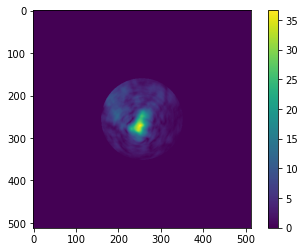

In [171]:
r0_tot = 0.02
L0 = 1e9
l0 = 1e-9
screen_width = 0.4
num_of_steps = 20 + 1
wavelength = 1550e-9
res = 512
l_pos_min = 0
p_max = 0
waist = 0.02
delz_step = delz/num_of_steps
inp = prop.BeamProfile(res, screen_width, wavelength)

mode_num = (p_max+1) * (l_pos_min*2 + 1) 

t_screens = [prop.PhaseScreen(
    screen_width, res, r0_tot * (num_of_steps - 1)**(3/5), l0, L0) for i in range(num_of_steps - 1)]

print(np.shape(t_screens))
print(delz_step)

for t in t_screens:
    t.mvk_screen()
    t.mvk_sh_screen()

# laguerre gaussian propataion
res_beam = np.zeros((2 * l_pos_min + 1, p_max + 1, res, res)) * (0 + 0j)
inp_arr = np.zeros((2 * l_pos_min + 1, p_max + 1, res, res)) * (0 + 0j)

for l in tqdm(range(-l_pos_min, l_pos_min + 1)):
    for p in range(p_max + 1):

        inp.laguerre_gaussian_beam(l, p, waist)

        inp.hard_ap(inp_ap_width)

        inp_arr[l + l_pos_min, p] = inp.field
        inp.free_space_prop(delz_step/2)
        for t in t_screens:
            phz_sc = t.phz + t.phz_lo

            inp.apply_phase_screen(phz_sc)
            inp.apply_sg_ap(0.9 * screen_width, 8)
            inp.free_space_prop(delz_step)
        inp.apply_sg_ap(0.9 * screen_width, 8)

        inp.free_space_prop(delz_step/2)

        inp.hard_ap(rec_ap_width)
        plt.imshow(np.abs(inp.field))
        plt.colorbar()
        inp.low_pass_filter(30)
        res_beam[l + l_pos_min, p] = inp.field

# hermite gaussian propagation
#k = 0

#res_beam = np.zeros((15, res, res)) * (0 + 0j)
#for n in range(5):
#    m_max = 5-n
#    for m in range(m_max): 
#        inp.hermite_gaussian_beam(n, m, waist)
#        inp.hard_ap(inp_ap_width)
#
#        inp.free_space_prop(delz_step/2)
#        for t in t_screens[0:-1]:
#            phz_sc = t.phz + t.phz_lo

 #           inp.apply_phase_screen(phz_sc)
 #           inp.apply_sg_ap(0.9 * screen_width, 8)
 #           inp.free_space_prop(delz_step)
#        inp.apply_sg_ap(0.9 * screen_width, 8)

#        inp.free_space_prop(delz_step/2)

 #       inp.hard_ap(rec_ap_width)
#        res_beam[k] = inp.field
#        k += 1



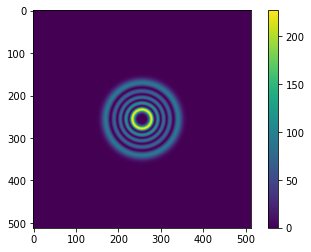

In [195]:
inp.laguerre_gaussian_beam(5, 4, 0.02)
inp.hard_ap(0.2)
plt.imshow(np.abs(inp.field) ** 2.0)
plt.colorbar()

In [ ]:
fig, (ax1, ax2, ax3, ax4) = [plt.subplots(2, 2)]
inp_plt = ax1.imshow(np.abs(inp.field))
res_plt = ax2.imshow(np.abs(res_beam[0, 0]))

In [24]:
#confirm that apertured input beams are orthogonal
cross = np.zeros((mode_num, mode_num))
beams = np.reshape(inp_arr, (mode_num, res, res))
for i in tqdm(range(mode_num)):
    for j in range(mode_num):
        beam_1 = np.reshape(beams[i], (res*res))
        beam_2 = np.reshape(beams[j], (res*res))

        cross[i, j] = np.abs(np.dot(beam_1, np.conj(beam_2)))

100%|██████████| 231/231 [01:11<00:00,  3.24it/s]


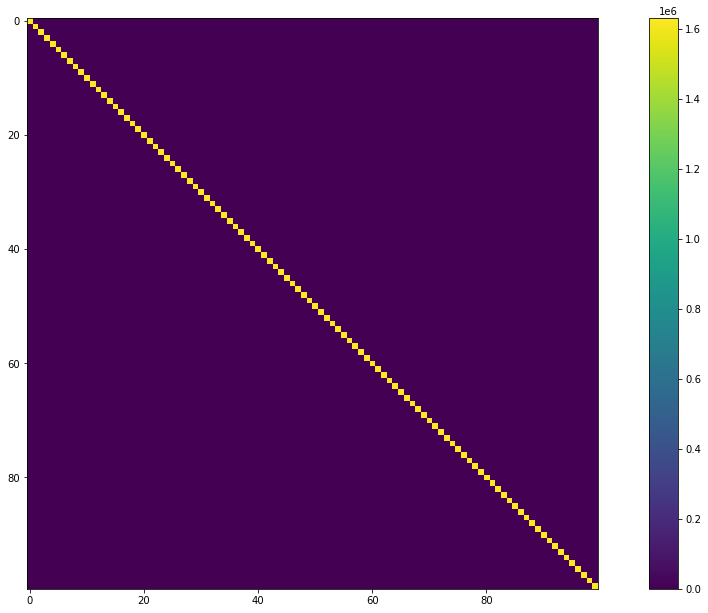

In [150]:

plt.imshow(cross[0:100, 0:100])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.colorbar()

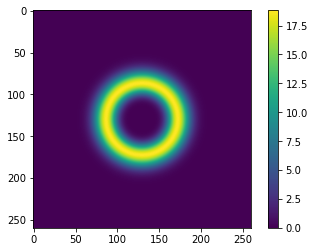

In [151]:
plt.imshow(np.abs(inp_arr[0, 0, 256-130:386, 126:386]))
plt.colorbar()


In [88]:
mode_num

32

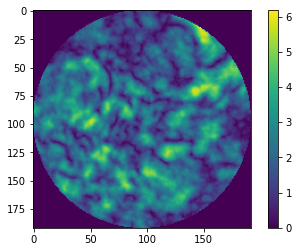

In [185]:
plt.imshow(np.abs(res_beam[0,10, 256-96:256+96, 256-96:256+96]))
plt.colorbar()

In [86]:
flt = np.reshape(inp_arr[0, 10], 512*512)
np.sum(flt * np.conj(flt))

(1137052.4931359694+0j)

In [174]:

compact_res = 512
low_bound = 256 - (compact_res//2)
hi_bound = 256 + (compact_res//2)

res_beam_flat = np.reshape(
    res_beam[:, :, low_bound:hi_bound, low_bound:hi_bound], (mode_num, compact_res, compact_res))

pixel_basis = np.ones((compact_res, compact_res))
t_mat = []

#probe_beams = np.zeros((15, compact_res*compact_res)) * (0 + 0j)

w0 = waist
k = 0
#for n in tqdm(range(5)):
#    m_max = 5 - n
#    for m in range(m_max):
        
#        probe_beam = prop.BeamProfile(res, screen_width, wavelength)
#        probe_beam.hermite_gaussian_beam(n, m, w0)
#        inp.hard_ap(inp_ap_width)
#        inp.free_space_prop(delz_step/2)
#        for t in t_screens[0:-1]:
        
#            inp.apply_phase_screen(phz_sc)
#            inp.apply_sg_ap(0.9 * screen_width, 8)
#            inp.free_space_prop(delz_step)
        
#        inp.apply_sg_ap(0.9 * screen_width, 8)
#        inp.free_space_prop(delz_step/2)
#        probe_fld = probe_beam.field
#        probe_beam_flat = np.reshape(probe_fld[256-70: 256+70, 256-70: 256+70], (compact_res * compact_res))
#        probe_beams[k] = probe_beam_flat
#        k += 1

for beam in tqdm(res_beam_flat):
    t_mat_tmp = []
    vec_beam = np.conj(np.reshape(beam, compact_res*compact_res))
#    for k in range(15):

#        olap = np.sum(vec_beam *  np.conj(probe_beams[k]))
#        t_mat_tmp.append(olap)
#    t_mat.append(t_mat_tmp)

# convert to 64-bit complex to aid svd calculation ram usage
    t_mat.append(vec_beam.astype('complex64'))


100%|██████████| 231/231 [00:00<00:00, 2093.11it/s]


In [175]:
#pixel basis decomposition
#clearing variables prevents ram overload
try:
    del(s)
    del(u)
    del(v)
except NameError:
    print('Name Error, at least one of the variables does not exist')

u, s, v = np.linalg.svd(np.asarray(t_mat).T, full_matrices = False)
print(s[0:15])


[1241.8387 1240.5353 1239.0793 1237.7738 1237.1838 1236.4441 1235.4108
 1234.1538 1233.5914 1232.533  1231.1554 1230.4053 1229.1212 1227.4298
 1226.7172]


In [756]:
# hg basis decomposition
try:
    del(s)
    del(u)
    del(v)
except NameError:
    print('Name Error, at least one of the variables does not exist')

u, s, v = np.linalg.svd(np.asarray(t_mat).T)
print(s[0:15]/s[0])

Name Error, at least one of the variables does not exist


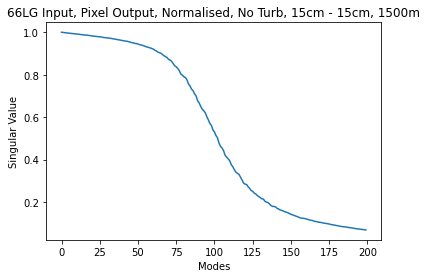

In [176]:
fig, ax = plt.subplots()
ax.plot(s[0:200]/s[0])
plt.title('66LG Input, Pixel Output, Normalised, No Turb, 15cm - 15cm, 1500m')
plt.ylabel('Singular Value')
plt.xlabel('Modes')

if 0:
    path = '/Users/ultandaly/Library/CloudStorage/OneDrive-UniversityofGlasgow/Projects/ecoc/svd_test_data/'

    title = '20220413_No_turb_pixel_decomp_66LG_Input_15cm-15cm_1500m_57_fs_modes'

    fig_dir = 'figs/'
    if not os.path.isfile(path + fig_dir + title + '.png'):
        plt.savefig(path + fig_dir + title + '.png', bbox_inches='tight')
    else:
        print('Warning: Image already exists. New image not saved')
    
    bin_dir = "data/"
    if not os.path.isfile(path + bin_dir + title + '.bin'):
        with open(path + bin_dir+ title + '.bin', "wb") as f:
            pickle.dump(s, f)
    else:
        print('Warning: .bin already exists')

plt.show()


In [186]:
np.shape(v)

(231, 231)

In [187]:
#there looks to be an issue here (or there is an issue with diffraction causing too much loss), look into and resolve this
exp_modes = 231

svd_trans_modes = np.zeros((exp_modes, res, res)) * (0 + 0j)
svd_rec_modes = np.zeros((1, exp_modes, res, res)) * (0 + 0j)

#inp_arr = np.zeros((2 * l_pos_min + 1, p_max + 1, res, res)) * (0 + 0j)

#for l in tqdm(range(-l_pos_min, l_pos_min + 1)):
#    for p in range(p_max + 1):
#        inp.laguerre_gaussian_beam(l, p, waist)
#        inp_arr[l + l_pos_min, p] =inp.field

inp_arr = np.reshape(inp_arr, (mode_num, res, res))


for k in tqdm(range(exp_modes)):
    for i, j in enumerate(inp_arr):
        #DO NOT CONJUGATE OR TRANSPOSE. NUMPY SVD RETURNS HERMITION V!!!!!!!!
        svd_trans_modes[k] += j * v[k, i]


#for n in range(5):
#    m_max = 5 - n
#    for m in range(m_max):
#        probe_beam.hermite_gaussian_beam(n, m, w0)
#        probe_fld = probe_beam.field
        
        
for k in range(exp_modes):
    print(np.sqrt(np.sum(np.abs(svd_trans_modes[k])**2.0)))
    svd_trans_modes[k] = svd_trans_modes[k] / np.sqrt(np.sum(np.abs(svd_trans_modes[k])**2.0))

for sig, new_wavelength in enumerate(range(1550, 1571, 40)):    
    print(new_wavelength)
    new_inp = prop.BeamProfile(res, screen_width, new_wavelength * 10 ** -9.0)
    new_inp.laguerre_gaussian_beam(0, 0, waist)
    for i, svd_mode in enumerate(svd_trans_modes):
        new_inp.field = svd_mode
        new_inp.hard_ap(inp_ap_width)

        new_inp.free_space_prop(delz_step/2)

        for t in t_screens:
            phz_sc = t.phz + t.phz_lo
            # adjust phz_sc for wavelength
            # I think its fair to assume that refractive index is constant over the range
            phz_sc = phz_sc * 1550e-9/(new_wavelength * 10 ** -9.0)
            new_inp.apply_phase_screen(phz_sc)
            new_inp.apply_sg_ap(0.9 * screen_width, 8)
            new_inp.free_space_prop(delz_step)
            
        new_inp.apply_sg_ap(0.9 * screen_width, 8)

        new_inp.free_space_prop(delz_step/2)

        new_inp.hard_ap(rec_ap_width)
        svd_rec_modes[sig, i] = new_inp.field


100%|██████████| 231/231 [00:17<00:00, 12.99it/s]


1277.3875857550518
1277.3860969164582
1277.4300222327038
1277.386900721891
1277.3680469103388
1277.423820155263
1277.3765389862294
1277.3832750049992
1277.3794178454418
1277.3302838091604
1277.3877641943864
1277.3637975452734
1277.3747014416595
1277.3784263146954
1277.3772835866234
1277.3226697626794
1277.2693510680015
1277.287969288188
1277.3014729710667
1277.2698632805723
1277.0087310289407
1277.1934333423142
1277.0655789291675
1277.190245969742
1277.088544894488
1277.132678046499
1277.0224779904352
1277.1824916949656
1277.1409500869172
1277.084934029018
1276.7600019642778
1276.7076147775888
1277.04135009042
1276.8062696886398
1276.701871167005
1276.66685907902
1276.9746052681264
1276.7056116239748
1276.4765605822781
1276.616485527893
1276.5509296664422
1276.3875901461086
1276.3791859502967
1276.6690708001238
1276.3991213220008
1276.2171048368098
1276.1386312994293
1275.42298237021
1276.026228099299
1276.1055247004103
1276.1584312402397
1275.3546536028864
1275.2812245673992
1275.1192

In [281]:
# calculate the error from my new modes when trying to represent the modes that I actually receive
reconstruct = np.zeros((231, 512, 512)) * (0 + 0j)
for i, rec in enumerate(tqdm(res_beam_flat)):
    for md in svd_rec_modes[0, 0:231]:
        olap = np.trapz(np.trapz(np.conj(md) * rec))
        reconstruct[i] += olap * md

err = np.zeros((231, 512, 512)) * (0 + 0j)
for i in range(1):

    err[i] = (reconstruct[i] - res_beam_flat[i])


100%|██████████| 231/231 [01:40<00:00,  2.30it/s]


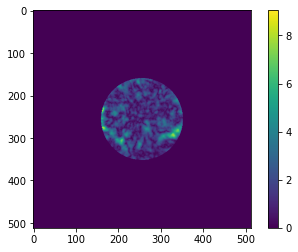

In [279]:
plt.imshow(np.abs(err[0]))
plt.colorbar()

In [280]:
np.sum(np.abs(err[0]) ** 2.0)

126216.080250237

In [282]:
np.sum(np.abs(err[0])**2.0)

200562.9381751564

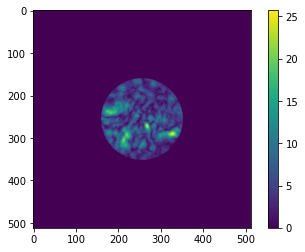

In [277]:
plt.imshow(np.abs(reconstruct[0] * 23/17.5))
plt.colorbar()

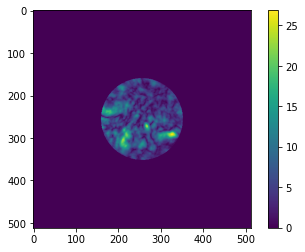

In [274]:
plt.imshow(np.abs(res_beam_flat[0]))
plt.colorbar()

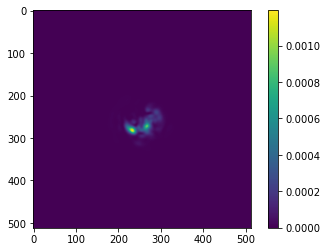

In [180]:
new_inp = prop.BeamProfile(res, screen_width, wavelength)
new_inp.field = svd_trans_modes[0]
#new_inp.hard_ap(inp_ap_width)

plt.imshow(np.abs(new_inp.field) ** 2.0)
plt.colorbar()

0.9222538897415953


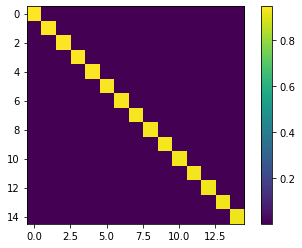

In [173]:
crosstlk = np.zeros((15, 15))
for i in range(15):
    for j in range(15):
        tmp1 = np.reshape(svd_rec_modes[5, i], (512,512))
        tmp2 = np.reshape(svd_rec_modes[5,j], (512, 512))
        crosstlk[i, j] = np.abs(np.trapz(np.trapz(tmp1 * np.conj(tmp2))))

plt.imshow(crosstlk)
plt.colorbar()
print(crosstlk[14, 14])

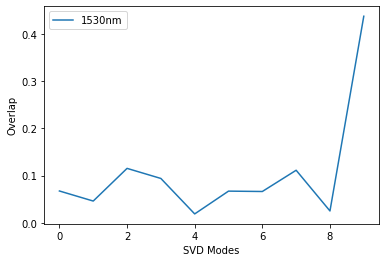

In [20]:
#check if crosstalk between SVD modes changes significantly wiht wavelength
test_mode = prop.BeamProfile(res, screen_width, new_wavelength * 10 ** -9.0)
test_mode.laguerre_gaussian_beam(l, p, waist)
#test_mode.hard_ap(inp_ap_width)

for i in range(1):
    test_mode.field = svd_rec_modes[i, 9]
    olap_hld = []
    for j in range(10):
        tmp1 = np.reshape(test_mode.field, (512,512))

        probe_mode = prop.BeamProfile(res, screen_width, new_wavelength * 10 ** -9.0)
        probe_mode.laguerre_gaussian_beam(l, p, waist)
        probe_mode.field = svd_rec_modes[0, j]
        #probe_mode.hard_ap(inp_ap_width)


        tmp2 = np.reshape(probe_mode.field, (512 , 512))
        tpz = np.trapz(np.trapz(tmp1 * np.conj(tmp2)))
        olap_hld.append(tpz)
        #olap_hld.append(np.dot(tmp1, np.conj(tmp2)))
    plt.plot(np.abs(olap_hld))

plt.legend(['1530nm', '1534nm', '1538nm', '1542nm', '1546nm', '1550nm', '1554nm', '1558nm', '1562nm', '1566nm', '1570nm'])
plt.xlabel('SVD Modes')
plt.ylabel('Overlap')
plt.show()

In [21]:
np.abs(olap_hld)

array([0.06745167, 0.04611408, 0.11538885, 0.09401576, 0.01883403,
       0.06715069, 0.06636801, 0.1114128 , 0.02512607, 0.43793388])

In [480]:
np.abs(np.inner(np.reshape(svd_rec_modes[0, 0], (512*512)), np.conj(np.reshape(svd_rec_modes[0, 9], (512*512)))))

0.012909254052838649

In [403]:
#need to compare square roots of the power to match singular values
np.sum(np.abs(svd_rec_modes[0]) ** 2.0)/np.sum(np.abs(svd_trans_modes[0]) ** 2.0)

0.8577331251769063

In [158]:
np.sum(np.abs(svd_mode_0)**2.0)


1.000000000000001

In [226]:
l = 1000
wavelength = 1550 * 10 **-9.0
tmp = prop.r0_to_cn2(0.02, 1550e-9, l)
1.229 * (10 ** tmp) * ((2*np.pi / wavelength)**(7/6)) * (l **(11/6))

1.9421736050435663

In [225]:
tmp = prop.r0_to_cn2(0.02, 1550e-9, 2000)
print(f"Proposed Turbulence Strength CN2 (assuming plane wave): {tmp}")

tmp = prop.r0_to_cn2(0.15/7.62, 809e-9, 1600)
print(f"Measured Turbulence Strength CN2 in Lavery 2017 (assuming plane wave): {tmp}")


Proposed Turbulence Strength CN2 (assuming plane wave): -13.311450029521305
Measured Turbulence Strength CN2 in Lavery 2017 (assuming plane wave): -13.767816856382787


In [171]:
2.99792458*10**8 / (190.4 * 10 **12)

1.5745402205882353e-06

In [65]:
np.log10(prop.r0_gaussian_to_cn2(0.15/7.62, 809e-9 ,1600, 0.01))

-13.386225314131398

In [134]:
10 ** -13.0104

9.763375665826406e-14

In [67]:
0.15/0.035

4.285714285714286

In [132]:
prop.r0_gaussian_to_cn2(0.025, 1550e-9 ,1000, 0.02)

1.0587744147545509e-13

In [106]:
0.15/7.62

0.01968503937007874

In [228]:
direc = '/Users/ultandaly/Library/CloudStorage/OneDrive-UniversityofGlasgow/Projects/python_simulation/svd_scripts/data/20230419/lg_prop_rep_many_inps/l_5_p_5_v002/'

res = np.load(direc + 'res_beams.npy')

inp = np.load(direc + 'inp_beams.npy')

t_screens = np.load(
    direc + 'turb_screens.npy')



In [229]:
np.shape(inp)

(66, 512, 512)

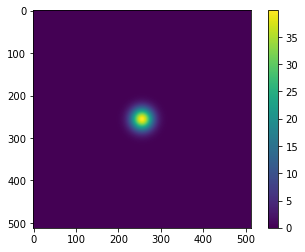

In [235]:
plt.imshow(np.abs(inp[30]))
plt.colorbar()

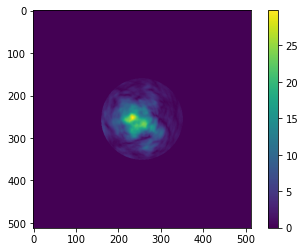

In [237]:
plt.imshow(np.abs(res[30]))
plt.colorbar()

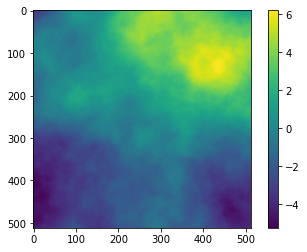

In [232]:
plt.imshow(np.real(t_screens[6]))
plt.colorbar()

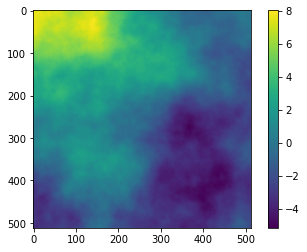

In [37]:
plt.imshow(np.real(t_screens[6]))
plt.colorbar()


In [283]:
time_step = 1
res = 512
mean_v = 3
del_v = 1
v_mags = np.abs(np.random.normal(mean_v, del_v, num_of_steps-1))

rnd_vecs = np.asarray([np.random.uniform(-1, 1, 2) for i in range(num_of_steps-1)])

for i, rnd in enumerate(rnd_vecs):
    rnd_vecs[i] = rnd/np.linalg.norm(rnd)

v_vals = np.asarray([v_mags * rnd_vecs[:, 0], v_mags * rnd_vecs[:, 1]])
pixel_vals = np.asarray([v_vals[:, 0] * time_step * res/ screen_width, v_vals[:, 1] * time_step * res/screen_width])
    

In [284]:
v_mags[0]

2.0524783274961718

In [285]:
rnd_vecs[0]

array([-0.95230912, -0.30513497])

In [286]:
v_vals[:, 0]

array([-1.95459382, -0.62628291])

In [287]:
pixel_vals[:, 0]

array([-2501.88009127,  -651.77066067])

In [289]:
2501.88009127 * pixel_width

1.9545938213046874

In [281]:
pixel_width = 0.4/512
pixel_width 

0.00078125

In [282]:
2.4477 / pixel_width

3133.056